In [10]:
import dask_jobqueue
import socket
from dask_jobqueue import LSFCluster
import os

In [11]:
node_memory = 256
n_workers_per_node = 4
memory = '{}GB'.format(node_memory/n_workers_per_node)
notebook_name = "jag"

In [12]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), header_skip=['-n ','-R','-M', '-P', '-W'], 
                     job_extra = ['-nnodes 1', '-G asccasc', '-W 00:30', '-o {}.log'.format(notebook_name), '-e {}.log'.format(notebook_name)], use_stdin=True, scheduler_options={'host': socket.gethostname()})

/p/gpfs1/haridev/software/spack/opt/spack/linux-rhel7-power9le/gcc-8.3.1/anaconda3-2021.05-ou5c3s4g5b6ac7d3ielq2ysjqrbmyvaj/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43283 instead
  warnings.warn(


In [13]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import time
from time import sleep

In [14]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:43283/status,
Dashboard: http://192.168.66.200:43283/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:42363,Workers: 0
Dashboard: http://192.168.66.200:43283/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [15]:
n_workers = 8

In [16]:
cluster.scale(n_workers)

In [17]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val< n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 0 of 8
8 workers started


In [18]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [19]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [20]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-jag-32-trace-3"

In [21]:
num_ranks = 128

In [22]:
#client.restart()

### process dataset per rank

In [23]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [24]:
ddf.npartitions

128

In [25]:
#client.cancel(ddf)

In [26]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [27]:
#ddf[0].head()

In [28]:
ddf = ddf[ddf['level'] == 0]
#ddf = ddf.persist()

In [29]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [30]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [31]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [32]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [33]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [34]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [35]:
#dd.compute(io_ddf['size'].unique(),io_ddf['count'].unique())

In [36]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [37]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [38]:
filenames = dd.compute(io_ddf['filename'].unique())

In [39]:
filenames = filenames[0].to_numpy()

In [40]:
for filename in filenames:
    print(filename)


%p
/p/gpfs1/haridev/software/lbann/applications/physics/ICF/20210908_125606_jag_wae/experiment.prototext
/p/gpfs1/brainusr/datasets/jag/jag100K1vw_train.npy


In [41]:
relevant_filenames = [k for k in filenames if '/p/gpfs1' in k]
print(relevant_filenames)

['/p/gpfs1/haridev/software/lbann/applications/physics/ICF/20210908_125606_jag_wae/experiment.prototext', '/p/gpfs1/brainusr/datasets/jag/jag100K1vw_train.npy']


In [42]:
file_df = io_ddf[io_ddf['filename'].isin(relevant_filenames)][['rank','filename','size', 'tstart', 'tend']].compute()

In [43]:
file_df

,rank,filename,size,tstart,tend
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,0,20.495499,20.495661
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,20.554550,20.568571
13976,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,31.896299,31.896345
22318,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,39.952942,39.952980
22320,0,/p/gpfs1/haridev/software/lbann/applications/p...,0,39.953400,39.953419
...,...,...,...,...,...
27249,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,0,40.301212,40.301228
27250,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,0,40.301285,40.301300
27251,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,11,40.301445,40.358921
27252,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,520709376,41.567333,47.632442


In [44]:
file_df = file_df.astype({'size': 'int32',})

In [45]:
correct_dur = ((file_df['tend'] - file_df['tstart']) > 0)

In [46]:
file_df['bandwidth'] = np.nan
file_df['bandwidth'] = file_df['bandwidth'].mask(correct_dur, file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0)

In [47]:
file_df

,rank,filename,size,tstart,tend,bandwidth
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,0,20.495499,20.495661,0.000000
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,20.554550,20.568571,0.557203
13976,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,31.896299,31.896345,170.666667
22318,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,39.952942,39.952980,204.800000
22320,0,/p/gpfs1/haridev/software/lbann/applications/p...,0,39.953400,39.953419,0.000000
...,...,...,...,...,...,...
27249,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,0,40.301212,40.301228,0.000000
27250,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,0,40.301285,40.301300,0.000000
27251,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,11,40.301445,40.358921,0.000183
27252,127,/p/gpfs1/brainusr/datasets/jag/jag100K1vw_trai...,520709376,41.567333,47.632442,81.876045


/p/gpfs1/haridev/software/lbann/applications/physics/ICF/20210908_125606_jag_wae/experiment.prototext


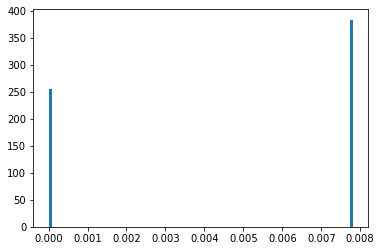

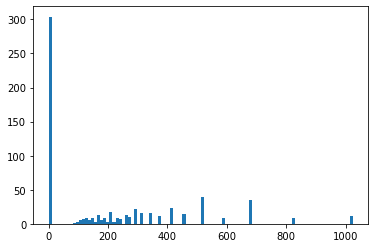

/p/gpfs1/brainusr/datasets/jag/jag100K1vw_train.npy


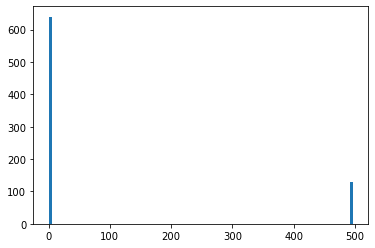

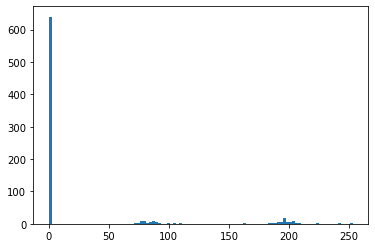

In [48]:
for filename in relevant_filenames:
    print(filename)
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'].to_numpy(), bins=100)
    plt.show()